# Vet a Known Exoplanet
This notebook pulls the parameters and light curve of a known exoplanet, WASP-18 b. It then runs three vetters on on that TCE and light curve. It is used as an example of how to run the vetters in the exovetter package.

In [1]:
import numpy as np
import requests
import matplotlib.pyplot as plt
import pandas as p
from IPython.display import display, HTML

from astropy import units as u
import lightkurve as lk
from exovetter import const as exo_const
from exovetter.model import create_box_model_for_tce
from exovetter.tce import Tce
from exovetter import vetters as vet

In [3]:
%matplotlib inline

planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
header={}

## Create a TCE using exo.MAST requests.
Since we are vetting a known exoplanet, we pull down the information about the exoplanet transit from exo.mast's API. We then create a TCE for vetting. A TCE is an object that contains the transit ephemeris and basic parameters that usually come out of a transit search pipeline (period, epoch, snr, depth).

In [4]:
planet_name = "WASP-18 b"

url = planeturl + "/identifiers/"
myparams = {"name":planet_name}
r = requests.get(url = url, params = myparams, headers = header)
planet_names = r.json()
ticid = planet_names['tessID']
tceid = planet_names['tessTCE']

In [5]:
url = planeturl + planet_name + "/properties/"

r = requests.get(url = url, headers = header)

planet_prop = r.json()
print("Catalog 2: " + planet_prop[1]['catalog_name'])
planet_prop[0].keys()
nexsci_prop = planet_prop[1]  #Second one returned

Catalog 2: nexsci


In [6]:
tce = Tce(period = nexsci_prop['orbital_period'] * u.day,
         epoch = nexsci_prop['transit_time'] * u.day,
         epoch_offset =  -2_400_000.5 * u.day,
         depth = nexsci_prop['transit_depth'] * exo_const.frac_amp,
         duration = nexsci_prop['transit_duration'] * u.day,
         snr = 50, #This value is only used by LPP and doesn't need to be very precise
         event_name = "WASP-18 b",
         target_name = "WASP-18")

# Get a lightkurve for this object
We use the lightkurve package to pull down sector 3 data for TESS data on this object. We then flatten that data to remove any remaining instrumental systematics.

In [7]:
lcf = lk.search_lightcurvefile(tce['target_name'], mission='TESS', sector = 3).download()
lc = lcf.SAP_FLUX.remove_nans().remove_outliers()
flat = lc.flatten(window_length=81)

/var/folders/qd/p48wml6j7313gsggzbjyyj000005fl/T/ipykernel_16532/3606397600.py:1: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  lcf = lk.search_lightcurvefile(tce['target_name'], mission='TESS', sector = 3).download()
/Users/mdallas/miniconda3/envs/exovetter_06_08/lib/python3.11/site-packages/lightkurve/search.py:414: LightkurveWarning: Warning: 8 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/var/folders/qd/p48wml6j7313gsggzbjyyj000005fl/T/ipykernel_16532/3606397600.py:2: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.SAP_FLUX.remove_nans().remove_outliers()


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

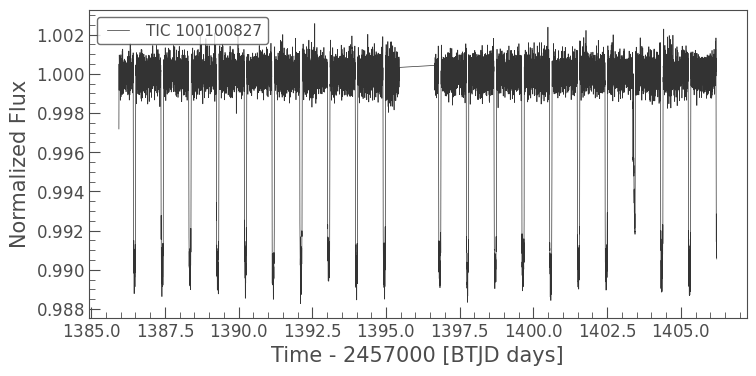

In [8]:
flat.plot()

In [9]:
lpp = vet.Lpp(lc_name="flux")
_ = lpp.run(tce,flat)

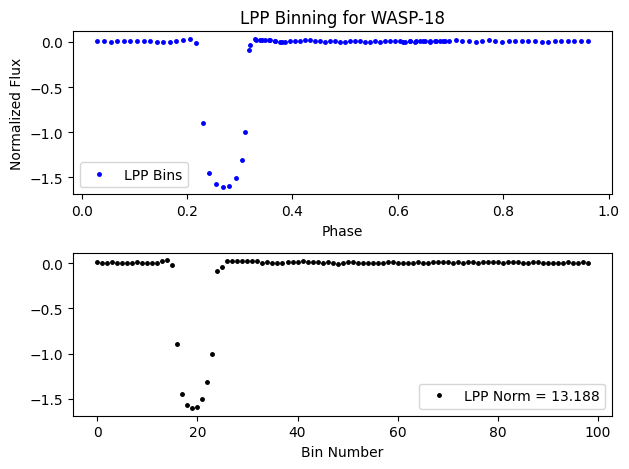

In [10]:
lpp.plot()

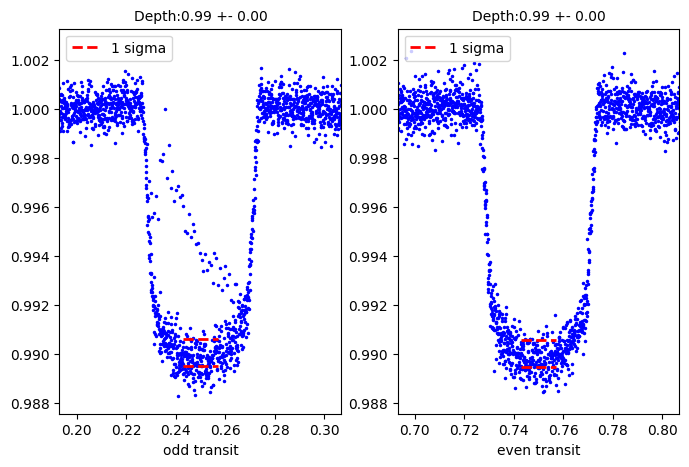

In [11]:
oe = vet.OddEven()
_ = oe.run(tce,flat)
oe.plot()

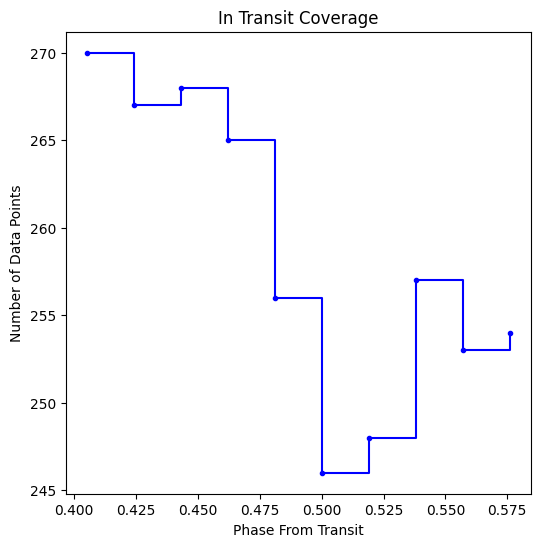

In [12]:
tcover = vet.TransitPhaseCoverage()
_ = tcover.run(tce,flat)
tcover.plot()

In [14]:
flat

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float64,float64,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1385.9396748966626,9.9718528e-01,5.2691175e-04,3.6872041e-03,114106,735.66635,506.34089,4.5683086e+04,2.4138899e+01,2.0175752e+03,6.3731475e+00,4.7450059e+04,2.5325798e+01,10000000000000,———,———,———,———,735.66635,4.8483591e-04,506.34089,5.2957161e-04,2.3226391e-01,2.2018807e-02
1385.94106377917,9.9965702e-01,5.2748353e-04,3.6871983e-03,114107,735.57013,506.33036,4.5794664e+04,2.4164219e+01,2.0135804e+03,6.3786530e+00,4.7499602e+04,2.5352362e+01,10000000000000,———,———,———,———,735.57013,4.8385921e-04,506.33036,5.3010089e-04,1.2177017e-01,6.4475504e-03
1385.9424526614443,9.9997401e-01,5.2740361e-04,3.6871922e-03,114108,735.52559,506.33865,4.5807527e+04,2.4159683e+01,1.9993990e+03,6.3590083e+00,4.7508332e+04,2.5347605e+01,10000000000000,———,———,———,———,735.52559,4.8406021e-04,506.33865,5.2970037e-04,7.1338244e-02,1.3642408e-02
1385.943841543718,9.9984122e-01,5.2747918e-04,3.6871862e-03,114109,735.50287,506.33695,4.5799828e+04,2.4162292e+01,1.9989005e+03,6.3787713e+00,4.7493039e+04,2.5350340e+01,10000000000000,———,———,———,———,735.50287,4.8410072e-04,506.33695,5.3030293e-04,4.5500640e-02,1.0682636e-02
1385.9452304259923,1.0004950e+00,5.2769115e-04,3.6871801e-03,114110,735.49011,506.33889,4.5828199e+04,2.4171171e+01,2.0027273e+03,6.3832922e+00,4.7518004e+04,2.5359655e+01,10000000000000,———,———,———,———,735.49011,4.8399874e-04,506.33889,5.3014379e-04,3.1429060e-02,1.2793540e-02
1385.946619308267,1.0000449e+00,5.2755125e-04,3.6871741e-03,114111,735.48380,506.33746,4.5806051e+04,2.4163954e+01,2.0003461e+03,6.3693099e+00,4.7493871e+04,2.5352085e+01,10000000000000,———,———,———,———,735.48380,4.8482287e-04,506.33746,5.3022435e-04,2.5112242e-02,1.1772516e-02
1385.9480081907734,9.9994368e-01,5.2749039e-04,3.6871682e-03,114112,735.48200,506.33218,4.5799922e+04,2.4160379e+01,2.0032877e+03,6.3738151e+00,4.7486438e+04,2.5348335e+01,10000000000000,———,———,———,———,735.48200,4.8440913e-04,506.33218,5.3047558e-04,2.3778629e-02,5.8564576e-03
1385.949397073047,9.9915624e-01,5.2741222e-04,3.6871622e-03,114113,735.47814,506.33472,4.5762406e+04,2.4156034e+01,2.0088591e+03,6.3824267e+00,4.7443465e+04,2.5343777e+01,10000000000000,———,———,———,———,735.47814,4.8491062e-04,506.33472,5.3079199e-04,1.9964756e-02,8.6351214e-03


In [17]:
michelle = vet.TessTransitEventStats()
michelle.run(tce,flat)

AttributeError: object has no attribute raw

In [12]:
tcover.lc_name

'flux'

In [ ]:
#Each Vetter can be returned as a dictionary
tcover.__dict__

In [ ]:
#Exovetter uses the lightcurve time_format for units on the times.
lc.time_format